In [2]:
# main imports
import os
import sys
import ast
import glob
import math
import shutil
import random
import importlib
import subprocess

from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.pylab as pylab
import upsetplot
import seaborn as sns

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 24
%matplotlib inline

pd.set_option('display.max_columns', None)

In [3]:
%load_ext autoreload
%autoreload 1

sys.path.insert(0, "") # directory to where definitions.py is
%aimport definitions

In [4]:
# paths

base_dir = "" # base directory for the analysis

orfanage_bin = "orfanage" # path to the orfanage binary
gffcompare_bin = "" # path to the gffcompare binary
gffread_bin = "" # path to the gffread binary
igvtools_bin = "" # path to the igvtools binary
sashimi_bin = "" # path to the sashimi.py binary (from the TieBrush package)

fa_fname = "hg38.fa" # path to the reference genome fasta file
gtf_fname = "gencode.v41.gtf" # path to the reference genome gtf file
mane_gtf_fname = "MANE.v10.gtf" # path to the MANE gtf file

gencode_outdir = base_dir+"gencode/"
refseq_outdir = base_dir+"refseq/"
figdir = base_dir+"figures/"

if not os.path.exists(figdir):
    os.makedirs(figdir)

In [5]:
# arguments
num_threads = 30

In [8]:
gdf = pd.read_csv(gencode_outdir+"df.tsv",sep="\t")
rdf = pd.read_csv(refseq_outdir+"df.tsv",sep="\t")
display(rdf.head())

tmp1 = gdf[["ilpd_def"]].reset_index(drop=True)
tmp1["db"] = "GENCODE"
tmp2 = rdf[["ilpd_def"]].reset_index(drop=True)
tmp2["db"] = "RefSeq"
cdf = pd.concat([tmp1,tmp2],axis=0)
cdf["all"] = "x"

,tid,has_cds_orf,seqid,strand,coords,chain_orf,has_cds_def,chain_def,mane_tid,chain_mane,mod_chain_orf,c1len_orf,c2len_orf,match_start_orf,match_end_orf,num_bp_extra_orf,num_bp_missing_orf,num_bp_inframe_orf,num_bp_match_orf,num_bp_outframe_orf,lpd_orf,ilpd_orf,mlpd_orf,mod_chain_def,c1len_def,c2len_def,match_start_def,match_end_def,num_bp_extra_def,num_bp_missing_def,num_bp_inframe_def,num_bp_match_def,num_bp_outframe_def,lpd_def,ilpd_def,mlpd_def
0,rna-XM_005244720.5,1,chr1,+,chr1:1308597-1310853,"[[1308644, 1308720], [1308915, 1308972], [1309...",1,"[[1308644, 1308720], [1308915, 1308972], [1309...",rna-NM_153339.3,"[[1308644, 1308720], [1308915, 1308972], [1309...","[[1308644, 1308720, 0], [1308915, 1308972, 0],...",687,912,True,False,13,238,473,674,201,75,51,73,"[[1308644, 1308720, 0], [1308915, 1308972, 0],...",687,912,True,False,13,238,473,674,201,75,51,73
1,rna-XM_047444716.1,1,chr1,+,chr1:1308597-1311016,"[[1308644, 1308720], [1308915, 1308972], [1309...",1,"[[1308644, 1308720], [1308915, 1308972], [1309...",rna-NM_153339.3,"[[1308644, 1308720], [1308915, 1308972], [1309...","[[1308644, 1308720, 0], [1308915, 1308972, 0],...",729,912,True,False,17,200,699,712,13,79,76,78,"[[1308644, 1308720, 0], [1308915, 1308972, 0],...",729,912,True,False,17,200,699,712,13,79,76,78
2,rna-XM_047444722.1,1,chr1,+,chr1:1308597-1311071,"[[1308644, 1308720], [1308915, 1308972], [1309...",1,"[[1308644, 1308720], [1308915, 1308972], [1309...",rna-NM_153339.3,"[[1308644, 1308720], [1308915, 1308972], [1309...","[[1308644, 1308720, 0], [1308915, 1308972, 0],...",687,912,True,False,0,225,473,687,214,75,51,75,"[[1308644, 1308720, 0], [1308915, 1308972, 0],...",687,912,True,False,0,225,473,687,214,75,51,75
3,rna-NM_001346116.2,1,chr1,+,chr1:1308597-1311677,"[[1308644, 1308720], [1308915, 1308972], [1309...",1,"[[1308644, 1308720], [1308915, 1308972], [1309...",rna-NM_153339.3,"[[1308644, 1308720], [1308915, 1308972], [1309...","[[1308644, 1308720, 0], [1308915, 1308972, 0],...",981,912,True,True,69,0,912,912,0,107,100,100,"[[1308644, 1308720, 0], [1308915, 1308972, 0],...",981,912,True,True,69,0,912,912,0,107,100,100
4,rna-NM_153339.3,1,chr1,+,chr1:1308597-1311677,"[[1308644, 1308720], [1308915, 1308972], [1309...",1,"[[1308644, 1308720], [1308915, 1308972], [1309...",rna-NM_153339.3,"[[1308644, 1308720], [1308915, 1308972], [1309...","[[1308644, 1308720, 0], [1308915, 1308972, 0],...",912,912,True,True,0,0,912,912,0,100,100,100,"[[1308644, 1308720, 0], [1308915, 1308972, 0],...",912,912,True,True,0,0,912,912,0,100,100,100


In [9]:
# how many non orfs are not the same?
print("percent of transcripts in RefSeq with the same chain as mane: "+str((len(rdf[rdf["chain_mane"]==rdf["chain_def"]])/len(rdf))*100))
print("percent of transcripts in RefSeq with the difference chain as mane: "+str((len(rdf[~(rdf["chain_mane"]==rdf["chain_def"])&\
                                                                                          (rdf["has_cds_def"]==1)])/len(rdf))*100))
print("percent of transcripts in RefSeq with no ORF: "+str((len(rdf[(rdf["has_cds_def"]==0)])/len(rdf))*100))

print("percent of transcripts in GENCODE with the same chain as mane: "+str((len(gdf[gdf["chain_mane"]==gdf["chain_def"]])/len(gdf))*100))
print("percent of transcripts in GENCODE with the difference chain as mane: "+str((len(gdf[~(gdf["chain_mane"]==gdf["chain_def"])&\
                                                                                           (gdf["has_cds_def"]==1)])/len(gdf))*100))
print("percent of transcripts in GENCODE with no ORF: "+str((len(gdf[(gdf["has_cds_def"]==0)])/len(gdf))*100))

percent of transcripts in RefSeq with the same chain as mane: 27.291553053193212
percent of transcripts in RefSeq with the difference chain as mane: 64.67861511931257
percent of transcripts in RefSeq with no ORF: 8.029831827494215
percent of transcripts in GENCODE with the same chain as mane: 20.505744976069096
percent of transcripts in GENCODE with the difference chain as mane: 36.365620566546625
percent of transcripts in GENCODE with no ORF: 43.12863445738428


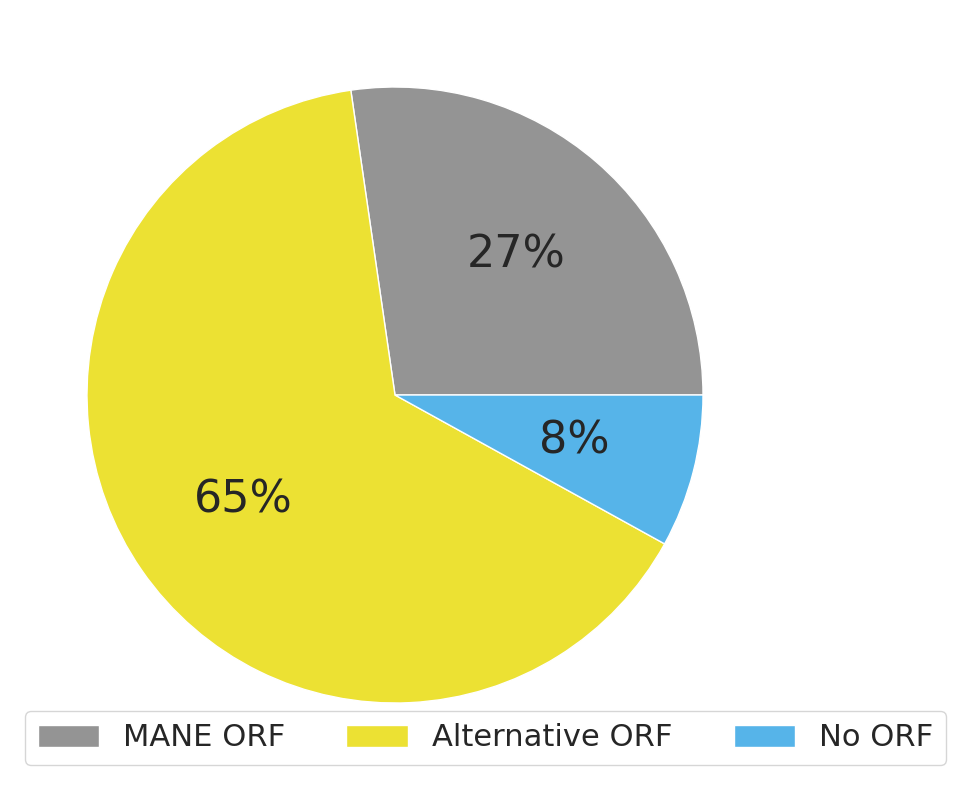

In [10]:
params = {'figure.figsize': (10,10),
          'legend.fontsize': 22,
          'axes.labelsize': 32,
          'axes.titlesize': 22,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22,
          'font.size': 32}
pylab.rcParams.update(params)

sns.set_style("white")

data = [(len(rdf[rdf["chain_mane"]==rdf["chain_def"]])/len(rdf))*100,
        (len(rdf[~(rdf["chain_mane"]==rdf["chain_def"])&(rdf["has_cds_def"]==1)])/len(rdf))*100,
        (len(rdf[(rdf["has_cds_def"]==0)])/len(rdf))*100]
labels = ["MANE ORF",
          "Alternative ORF",
          "No ORF"]
plt.pie(data, autopct='%.0f%%',colors=sns.color_palette("colorblind")[7:])
# plt.legend(labels, loc="right",bbox_to_anchor=(1.5, 0.5))
plt.legend(labels, loc="lower left", ncol=3)
plt.savefig(figdir+"refseq_orfs.svg")
plt.show()

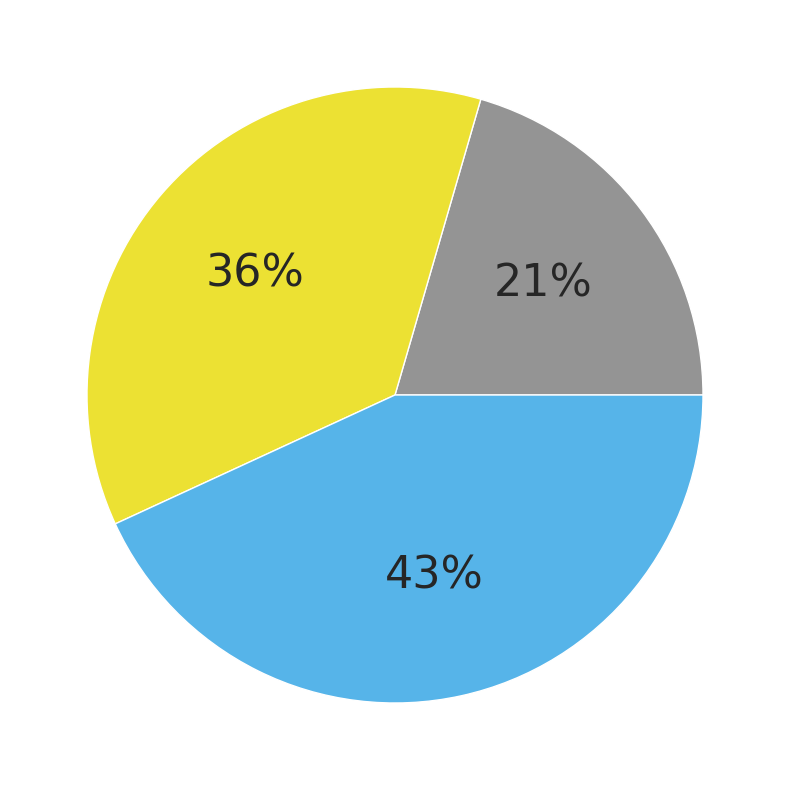

In [11]:
data = [(len(gdf[gdf["chain_mane"]==gdf["chain_def"]])/len(gdf))*100,
        (len(gdf[~(gdf["chain_mane"]==gdf["chain_def"])&(gdf["has_cds_def"]==1)])/len(gdf))*100,
        (len(gdf[(gdf["has_cds_def"]==0)])/len(gdf))*100]
labels = ["MANE ORF",
          "Alternative ORF",
          "No ORF"]
plt.pie(data, autopct='%.0f%%',colors=sns.color_palette("colorblind")[7:])
plt.savefig(figdir+"gencode_orfs.svg")
plt.show()

In [6]:
# get matching/mismatching plot for bootstrapping
boot_df = pd.DataFrame()

res = pd.read_csv(base_dir+"refseq/orf.rand.tsv",sep="\t")
res["perc"] = (res["perc"]*100).astype(int)
res["ntxs"] = res["missing"]+res["mismatching"]+res["matching"]
res["missing%"] = (res["missing"].astype(float)/res["ntxs"].astype(float))*100.0
res["mismatching%"] = (res["mismatching"].astype(float)/res["ntxs"].astype(float))*100.0
res["matching%"] = (res["matching"].astype(float)/res["ntxs"].astype(float))*100.0
res.drop(["iter","missing","matching","mismatching","ntxs"],axis=1,inplace=True)
res[" "] = "RefSeq"
boot_df = pd.concat([boot_df,res],axis=0)

res = pd.read_csv(base_dir+"gencode/orf.rand.tsv",sep="\t")
res["perc"] = (res["perc"]*100).astype(int)
res["ntxs"] = res["missing"]+res["mismatching"]+res["matching"]
res["missing%"] = (res["missing"].astype(float)/res["ntxs"].astype(float))*100.0
res["mismatching%"] = (res["mismatching"].astype(float)/res["ntxs"].astype(float))*100.0
res["matching%"] = (res["matching"].astype(float)/res["ntxs"].astype(float))*100.0
res.drop(["iter","missing","matching","mismatching","ntxs"],axis=1,inplace=True)
res[" "] = "GENCODE"
boot_df = pd.concat([boot_df,res],axis=0)

res = pd.read_csv(base_dir+"arabidopsis_rev2/orf.rand.tsv",sep="\t")
res["perc"] = (res["perc"]*100).astype(int)
res["ntxs"] = res["missing"]+res["mismatching"]+res["matching"]
res["missing%"] = (res["missing"].astype(float)/res["ntxs"].astype(float))*100.0
res["mismatching%"] = (res["mismatching"].astype(float)/res["ntxs"].astype(float))*100.0
res["matching%"] = (res["matching"].astype(float)/res["ntxs"].astype(float))*100.0
res.drop(["iter","missing","matching","mismatching","ntxs"],axis=1,inplace=True)
res[" "] = "A.thaliana"
boot_df = pd.concat([boot_df,res],axis=0)

res = pd.read_csv(base_dir+"celegans_rev2/orf.rand.tsv",sep="\t")
res["perc"] = (res["perc"]*100).astype(int)
res["ntxs"] = res["missing"]+res["mismatching"]+res["matching"]
res["missing%"] = (res["missing"].astype(float)/res["ntxs"].astype(float))*100.0
res["mismatching%"] = (res["mismatching"].astype(float)/res["ntxs"].astype(float))*100.0
res["matching%"] = (res["matching"].astype(float)/res["ntxs"].astype(float))*100.0
res.drop(["iter","missing","matching","mismatching","ntxs"],axis=1,inplace=True)
res[" "] = "C.elegans"
boot_df = pd.concat([boot_df,res],axis=0)

boot_df["perc"] = np.where(boot_df["perc"]==0,1,boot_df["perc"])
boot_df.head()

,perc,mean_ilpd,missing%,mismatching%,matching%,
0,1,96.262626,0.414509,14.249383,85.336108,RefSeq
1,1,96.177804,0.410398,14.467969,85.121633,RefSeq
2,1,96.109506,0.413687,14.556669,85.029643,RefSeq
3,1,96.113851,0.426842,14.783441,84.789716,RefSeq
4,1,96.193236,0.506402,14.937257,84.556341,RefSeq


In [7]:
boot_df.rename({" ":"dataset","mean_ilpd":"mean_ilpi"},axis=1).to_csv(figdir+"bootstrap.csv",index=False)

In [8]:
boot_df.groupby(by=["perc"," "]).mean()

mean_ilpd  missing%  mismatching%  matching%
perc                                                         
1    A.thaliana  98.593743  0.031371      7.975656  91.992972
     C.elegans   92.278458  0.928644     22.492621  76.578735
     GENCODE     89.061708  1.887580     17.047072  81.065348
     RefSeq      96.094088  0.430191     14.837533  84.732276
25   A.thaliana  98.722991  0.022410      7.477682  92.499908
     C.elegans   93.330663  0.651111     20.211420  79.137469
     GENCODE     90.649198  0.959249     14.392697  84.648054
     RefSeq      98.395407  0.115615      6.756245  93.128140
50   A.thaliana  99.187768  0.011846      5.085950  94.902204
     C.elegans   95.299967  0.348110     14.999149  84.652742
     GENCODE     94.013129  0.179729      8.905946  90.914325
     RefSeq      99.387449  0.019401      2.793336  97.187263
75   A.thaliana  99.540660  0.006724      3.000158  96.993118
     C.elegans   96.990745  0.169286      9.941250  89.889464
     GENCODE     96.671520  0.037313      4.802619  95.160068
     RefSeq      99.743867  0.004300      1.189659  98.806041

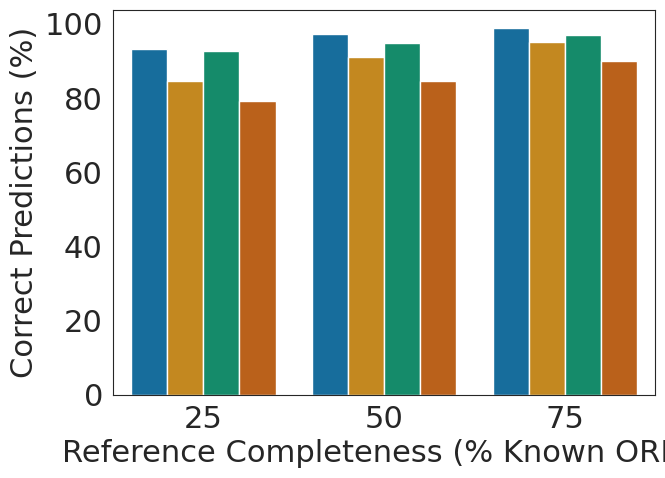

In [20]:
params = {'figure.figsize': (7,5),
          'legend.fontsize': 22,
          'axes.labelsize': 22,
          'axes.titlesize': 22,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22}
pylab.rcParams.update(params)

sns.set_style("white")
ax = sns.barplot(x="perc", y="matching%", hue=" ", data=boot_df[boot_df["perc"]>1],errorbar=None,palette="colorblind")
plt.legend([],[], frameon=False)
plt.xlabel("Reference Completeness (% Known ORFs)")
plt.ylabel("Correct Predictions (%)")
plt.savefig(figdir+"bootstrap.correct.svg")

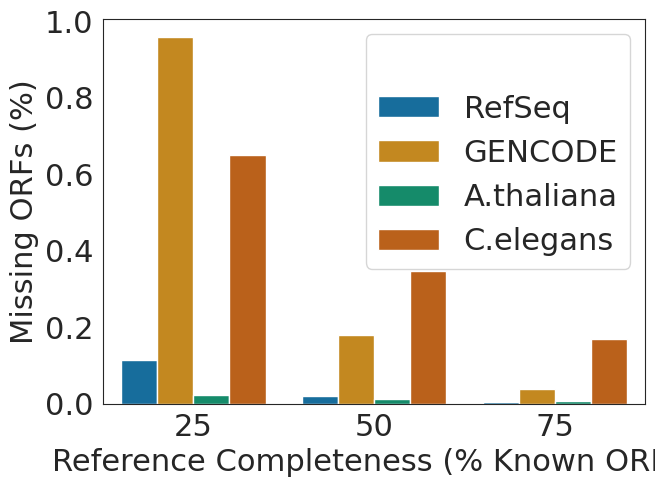

In [21]:
sns.set_style("white")
ax = sns.barplot(x="perc", y="missing%", hue=" ", data=boot_df[boot_df["perc"]>1],errorbar=None,palette="colorblind")
sns.move_legend(ax, "upper right")
plt.xlabel("Reference Completeness (% Known ORFs)")
plt.ylabel("Missing ORFs (%)")
plt.savefig(figdir+"bootstrap.missing.svg")